<a href="https://colab.research.google.com/github/DevBatra05/DeepLearningLab/blob/main/Project_1_With_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 0: Basic imports

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns


In [2]:
# STEP 1: Mount Google Drive (if not already)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# STEP 1.1: Unzip your dataset (only once; then you can skip this cell later)

zip_path = '/content/drive/MyDrive/archive (6).zip'
extract_path = '/content/alzheimer_dataset'

import zipfile

if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted.")
else:
    print("Dataset already extracted at:", extract_path)


Dataset extracted.


In [5]:
# STEP 1.2: Set base_dir, train_dir, test_dir correctly

base_dir = os.path.join(extract_path, "Combined Dataset")

train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

print("Base dir :", base_dir)
print("Train dir:", train_dir)
print("Test dir :", test_dir)

# Just to double-check structure:
print("\nTrain subfolders:")
print(os.listdir(train_dir))

print("\nTest subfolders:")
print(os.listdir(test_dir))


Base dir : /content/alzheimer_dataset/Combined Dataset
Train dir: /content/alzheimer_dataset/Combined Dataset/train
Test dir : /content/alzheimer_dataset/Combined Dataset/test

Train subfolders:
['Very Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Mild Impairment']

Test subfolders:
['Very Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Mild Impairment']


In [6]:
# STEP 2: ImageDataGenerators with augmentation for training

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% val from train_dir
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
print("Class indices:", class_indices)


Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Class indices: {'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}


In [7]:
idx_to_class = {v: k for k, v in class_indices.items()}
print(idx_to_class)


{0: 'Mild Impairment', 1: 'Moderate Impairment', 2: 'No Impairment', 3: 'Very Mild Impairment'}


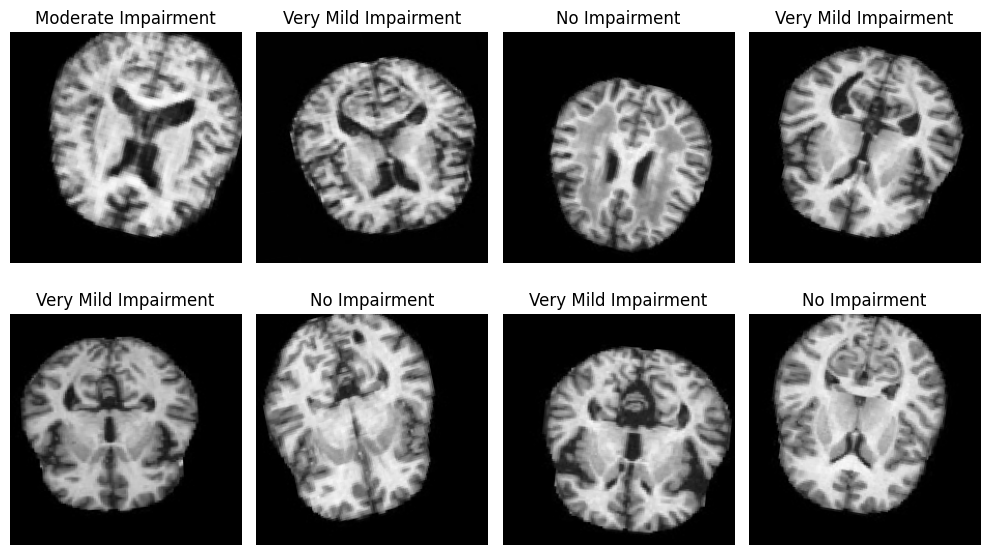

In [8]:
# STEP 3: Visualize some training images with labels

x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
    label_idx = np.argmax(y_batch[i])
    label_name = list(class_indices.keys())[list(class_indices.values()).index(label_idx)]
    plt.title(label_name)
plt.tight_layout()
plt.show()


In [9]:
# STEP 4: Baseline CNN model

baseline_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
baseline_checkpoint = ModelCheckpoint(
    filepath='baseline_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

baseline_early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

baseline_lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

baseline_callbacks = [baseline_checkpoint, baseline_early_stop, baseline_lr_reduce]


In [ ]:
baseline_history = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=baseline_callbacks
)


In [12]:
# STEP 5: MobileNetV2 Transfer Learning

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # freeze base for initial training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=outputs)

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
checkpoint = ModelCheckpoint(
    filepath='mobilenetv2_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stop, lr_reduce]


In [14]:
EPOCHS = 10  # can increase to 12–15 if time is okay

mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4533 - loss: 1.2529
Epoch 1: val_accuracy improved from -inf to 0.63037, saving model to mobilenetv2_best_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 608s 2s/step - accuracy: 0.4537 - loss: 1.2522 - val_accuracy: 0.6304 - val_loss: 0.8264 - learning_rate: 0.0010
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6445 - loss: 0.8258
Epoch 2: val_accuracy improved from 0.63037 to 0.63477, saving model to mobilenetv2_best_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.6445 - loss: 0.8258 - val_accuracy: 0.6348 - val_loss: 0.7542 - learning_rate: 0.0010
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6905 - loss: 0.7395
Epoch 3: val_accuracy improved from 0.63477 to 0.67529, saving model to mobilenetv2_best_model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.6905 - loss: 0.7395 - val_accuracy: 0.6753 - val_loss: 0.7298 - learning_rate: 0.0010
Epoch 4/10
256/256 

In [15]:
# STEP 5.1: Fine-tune some layers

base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

FINE_TUNE_EPOCHS = 5

mobilenet_ft_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=callbacks
)


Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6665 - loss: 0.8832
Epoch 1: val_accuracy did not improve from 0.67529
256/256 ━━━━━━━━━━━━━━━━━━━━ 708s 3s/step - accuracy: 0.6667 - loss: 0.8823 - val_accuracy: 0.4771 - val_loss: 1.8439 - learning_rate: 1.0000e-04
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7826 - loss: 0.5045
Epoch 2: val_accuracy did not improve from 0.67529
256/256 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.7826 - loss: 0.5044 - val_accuracy: 0.5459 - val_loss: 1.0817 - learning_rate: 1.0000e-04
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8270 - loss: 0.4125
Epoch 3: val_accuracy did not improve from 0.67529
256/256 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - accuracy: 0.8270 - loss: 0.4126 - val_accuracy: 0.5049 - val_loss: 1.1485 - learning_rate: 1.0000e-04
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8345 - loss: 0.3934
Epoch 4: val_accuracy did not improve from 0.67529

Epoch 4: ReduceLROnPl

In [16]:
def plot_history(history, title_prefix=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


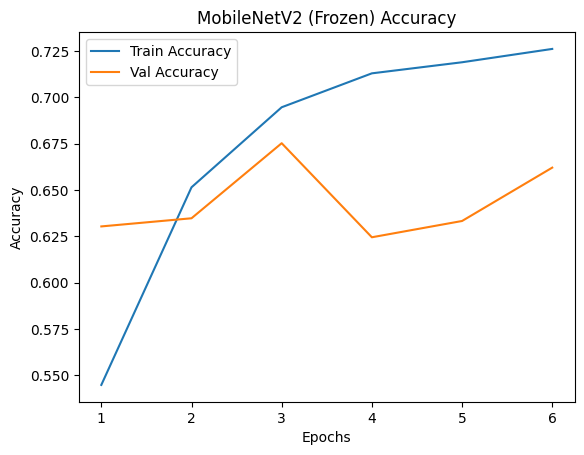

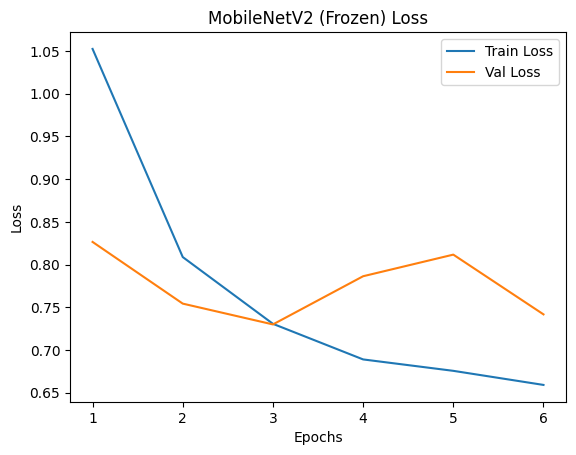

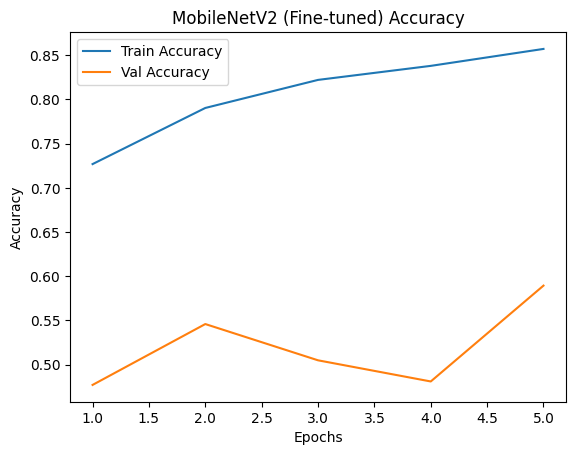

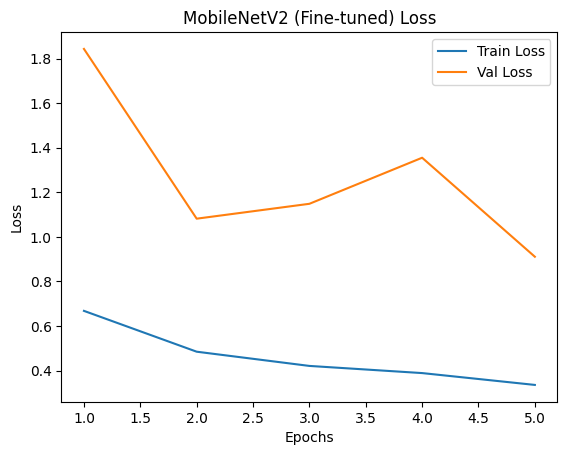

In [18]:


# MobileNetV2 curves (initial training)
plot_history(mobilenet_history, "MobileNetV2 (Frozen)")

# Fine-tuned MobileNetV2 curves (if run)
try:
    plot_history(mobilenet_ft_history, "MobileNetV2 (Fine-tuned)")
except:
    print("Fine-tuning not performed or history not available.")


In [19]:
# STEP 7: Evaluate on test data

test_loss, test_acc = mobilenet_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5417 - loss: 1.1614
Test Loss: 1.4288893938064575
Test Accuracy: 0.39483970403671265


In [20]:
# Get true labels and predicted labels for test set

test_generator.reset()
y_prob = mobilenet_model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

target_names = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))


40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step
Classification Report:

                      precision    recall  f1-score   support

     Mild Impairment       0.22      0.94      0.36       179
 Moderate Impairment       1.00      0.50      0.67        12
       No Impairment       0.91      0.28      0.43       640
Very Mild Impairment       0.48      0.34      0.40       448

            accuracy                           0.39      1279
           macro avg       0.65      0.51      0.46      1279
        weighted avg       0.66      0.39      0.41      1279



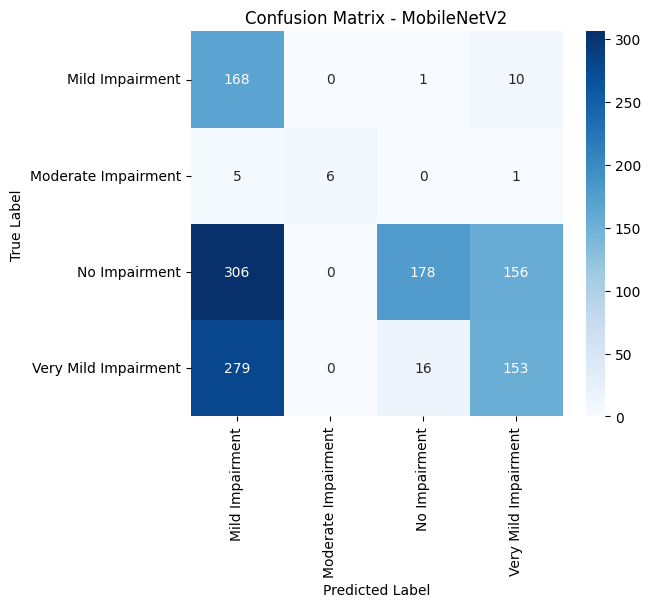

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()


In [22]:
# For AUC, we use one-vs-rest multi-class AUC
# Need one-hot true labels

y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(target_names))

try:
    auc_macro = roc_auc_score(y_true_onehot, y_prob, multi_class='ovr', average='macro')
    print("Macro AUC (OvR):", auc_macro)
except Exception as e:
    print("Could not compute AUC:", e)


Macro AUC (OvR): 0.82328023685091


In [23]:
from tensorflow.keras.preprocessing import image

idx_to_class = {v:k for k,v in class_indices.items()}
print("Index to class mapping:", idx_to_class)

def predict_mri_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    probs = mobilenet_model.predict(img_array)[0]
    pred_idx = np.argmax(probs)
    pred_class = idx_to_class[pred_idx]
    confidence = probs[pred_idx]

    print(f"Predicted Class: {pred_class}")
    print(f"Confidence: {confidence:.4f}")
    print("Class-wise probabilities:")
    for i, cls in idx_to_class.items():
        print(f"{cls}: {probs[i]:.4f}")

    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f})")
    plt.show()

# Example usage (update path):
# predict_mri_image('/content/sample_mri.jpg')


Index to class mapping: {0: 'Mild Impairment', 1: 'Moderate Impairment', 2: 'No Impairment', 3: 'Very Mild Impairment'}


In [24]:
save_path = '/content/drive/MyDrive/Alzheimer_MobileNetV2.keras'
mobilenet_model.save(save_path)
print("Model saved at:", save_path)


Model saved at: /content/drive/MyDrive/Alzheimer_MobileNetV2.keras
